<a href="https://colab.research.google.com/github/KamaljeetSahoo/Image-Classification-CIFAR10-BasicCNN/blob/master/CIFAR_10.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Image Classification using CIFAR-10 dataset

### Imports

In [ ]:
import torch
import torchvision
import torchvision.transforms as transforms
import time

### Dataset and DataLoader

In [ ]:
transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

batch = 4

trainset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch, shuffle=True, num_workers=2)

testset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=batch, shuffle=False, num_workers=2, drop_last=True)

classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

Files already downloaded and verified
Files already downloaded and verified


### Visualisation

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

In [ ]:
def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

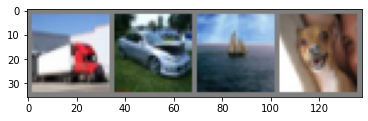

truck   car  ship   dog


In [ ]:
# get some random training images
dataiter = iter(trainloader)
images, labels = dataiter.next()

# show images
imshow(torchvision.utils.make_grid(images))
# print labels
print(' '.join('%5s' % classes[labels[j]] for j in range(batch)))

### Model

In [ ]:
import torch.nn as nn
import torch.nn.functional as F

In [ ]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(3, 6, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(16 * 5 * 5, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, 16 * 5 * 5)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

### Training utils, Loss and Optimiser

In [ ]:
#check if cuda available
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device

device(type='cuda', index=0)

In [ ]:
step = 0
loss_train = []
loss_val = []

#import the model
net = Net()
net = net.to(device)
net = net.train()

min_loss = 100
patience = 5
training_loss_store = []
validation_loss_store = []

In [ ]:
import torch.optim as optim
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)

### Training

In [ ]:
file = open('logs_test4_epoch100_with_max_pool.txt', 'w')

print('training started.............................................')
file.write('training started.............................................\n')
start_time = time.time()
for epoch in range(150):  # loop over the dataset multiple times
    #file.write('##############################TRAINING###############################\n')
    running_loss = 0.0
    for i, data in enumerate(trainloader, 0):
        step+=1
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data[0].to(device),data[1].to(device)

        # zero the parameter gradients
        optimizer.zero_grad()
        # forward + backward + optimize
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss_train.append(loss.item())
        training_loss_store.append([epoch, loss.item()])
        loss.backward()
        optimizer.step()

        # print statistics
        running_loss += loss.item()
        if i % 20 == 19:    # print every 10 mini-batches
            print('[%d, %5d] loss: %.5f' %(epoch + 1, i + 1, running_loss / 2000))
            #log_loss_summary(logger, loss_train, step, prefix = 'train_')
            file.write('epoch = '+ str(epoch + 1) + '\t' +'step = '+ str(step) +'\t'+'train_loss = '+'\t'+str(np.mean(loss_train)) +'\n')
            loss_train = []
            running_loss = 0.0
            
    print('Finished training for epoch ' + str(epoch) + ' time taken = ' + str(time.time() - start_time))
    file.write('Finished training for epoch ' + str(epoch) + ' time taken = ' + str(time.time() - start_time) + '\n')
    file.write('##################################evaluation##############################\n')
    print('################################evaluation###########################\n')
    with torch.no_grad():
        val_loss = 0
        net.eval()
        
        for i, data in enumerate(testloader, 0):
            step+=1
            inputs, labels = data[0].to(device),data[1].to(device)
            outputs = net(inputs)
            loss = criterion(outputs, labels)
            loss_val.append(loss.item())
            validation_loss_store.append([epoch, loss.item()])
            val_loss += loss
            
        val_loss = val_loss/float(i + 1)
        
        if val_loss < min_loss:
            min_loss = val_loss
            no_impr_epoch = 0
            
            #save the best model
            #torch.save(net.state_dict(), 'weight/' + 'epoch_' + str(epoch+1) + 'loss_' + str(val_loss) + '.pt')
            print(str(val_loss))
            torch.save(net.state_dict(), 'xyz_epoch_'+str(epoch+1)+'.pt')
            
            print('performance improved with validation loss ' + str(val_loss))
            file.write('--------------------------------------------------------------------\n')
            file.write('performance improved with validation loss =  ' + str(val_loss) + '\n')
            
            file.write('epoch = '+ str(epoch + 1) + '\t' +'step = '+ str(step) +'\t'+'val_loss = '+'\t'+str(np.mean(loss_val)) +'\n')
            file.write('--------------------------------------------------------------------\n\n')
            #log_loss_summary(logger, loss_val, step, prefix="val_")
            loss_val = []
        else:
            no_impr_epoch += 1
            print('no improvement with prev best model ' + str(no_impr_epoch) + 'th')
            file.write('no improvement with prev best model ' + str(no_impr_epoch) + 'th \n')
            
        if no_impr_epoch > patience:
            print('stop training')
            file.write('stop training')
            break
    
print('Finished Training................................................')
file.write('Finished Training................................................\n')
end_time = time.time()
file.write('Training time:- ' + str(end_time - start_time))
file.close()

training started.............................................
[1,    20] loss: 0.02306
[1,    40] loss: 0.02305
Finished training for epoch 0 time taken = 8.573033332824707
################################evaluation###########################

tensor(2.3047, device='cuda:0')
performance improved with validation loss tensor(2.3047, device='cuda:0')
[2,    20] loss: 0.02304
[2,    40] loss: 0.02305
Finished training for epoch 1 time taken = 18.812028408050537
################################evaluation###########################

tensor(2.3039, device='cuda:0')
performance improved with validation loss tensor(2.3039, device='cuda:0')
[3,    20] loss: 0.02304
[3,    40] loss: 0.02304
Finished training for epoch 2 time taken = 28.99104952812195
################################evaluation###########################

tensor(2.3031, device='cuda:0')
performance improved with validation loss tensor(2.3031, device='cuda:0')
[4,    20] loss: 0.02303
[4,    40] loss: 0.02303
Finished training for e

### Load Model

In [ ]:
PATH = 'xyz_epoch_149.pt'
model = Net()
model.load_state_dict(torch.load(PATH))
model.eval()

Net(
  (conv1): Conv2d(3, 6, kernel_size=(5, 5), stride=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
  (fc1): Linear(in_features=400, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (fc3): Linear(in_features=84, out_features=10, bias=True)
)

### Testing

In [ ]:
dataiter = iter(testloader)
images, labels = dataiter.next()

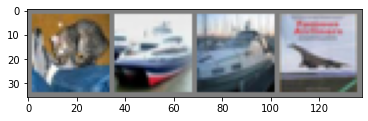

Ground Truth:    cat  ship  ship plane


In [ ]:
# show images
imshow(torchvision.utils.make_grid(images))
# print labels
print('Ground Truth: ', ' '.join('%5s' % classes[labels[j]] for j in range(batch)))

In [ ]:
outputs = model(images)
_, predicted = torch.max(outputs, 1)

print('Predicted: ', ' '.join('%5s' % classes[predicted[j]]
                              for j in range(batch)))

Predicted:   frog  ship  ship  ship


### Accuracy

In [ ]:
correct = 0
total = 0
with torch.no_grad():
    for data in testloader:
        images, labels = data[0], data[1]
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print('Accuracy of the network on the 3776 test images: %d %%' % (100 * correct / total))

Accuracy of the network on the 3776 test images: 53 %


In [ ]:
class_correct = list(0. for i in range(10))
class_total = list(0. for i in range(10))
with torch.no_grad():
    for data in testloader:
        images, labels = data[0].to(device), data[1].to(device)
        outputs = net(images)
        _, predicted = torch.max(outputs, 1)
        c = (predicted == labels).squeeze()
        for i in range(batch):
            label = labels[i]
            class_correct[label] += c[i].item()
            class_total[label] += 1


for i in range(10):
    print('Accuracy of %5s : %2d %%' % (
        classes[i], 100 * class_correct[i] / class_total[i]))

Accuracy of plane : 56 %
Accuracy of   car : 76 %
Accuracy of  bird : 33 %
Accuracy of   cat : 33 %
Accuracy of  deer : 43 %
Accuracy of   dog : 39 %
Accuracy of  frog : 72 %
Accuracy of horse : 57 %
Accuracy of  ship : 70 %
Accuracy of truck : 47 %


### Test on a single image

In [ ]:
from google.colab import files
import os

In [ ]:
uploaded = files.upload()
dst ='image.jpg' 
os.rename(list(uploaded.keys())[0], dst)

Saving silje-midtgard-0F9oVQ3x2ak-unsplash.jpg to silje-midtgard-0F9oVQ3x2ak-unsplash.jpg


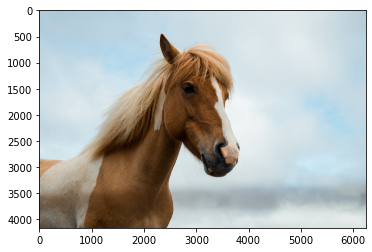

In [ ]:
plt.imshow(np.asarray(Image.open('image.jpg')))

In [ ]:
testing_transforms = transforms.Compose([transforms.Resize((32,32)), transforms.ToTensor(), transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

In [ ]:
input = testing_transforms(Image.open('image.jpg'))

In [ ]:
output = model(input.unsqueeze(0))
_, predicted = torch.max(output, 1)
print(classes[predicted])

cat
